# B

In [1]:
n = 5
1-(1-1/n)^n

[1] 0.67232

In [2]:
n = 10
1-(1-1/n)^n

[1] 0.6513216

In [3]:
n = 100
1-(1-1/n)^n

[1] 0.6339677

In [4]:
n = 1000
1-(1-1/n)^n

[1] 0.6323046

# 1 C

Computing two very large values for n we see that the values always stay around 0.632

In [5]:
n = 100000000
1-(1-1/n)^n

[1] 0.6321206

In [6]:
n = 500000000000
1-(1-1/n)^n

[1] 0.6321124

We also know from calculus that $lim$ as $ n \to \infty$ $(1+x/n)^n = e^x$. Which shows us that as n approaches infinity the value will always equal 0.632. Which matches what we have shown above for very large numbers of n.
We can write this equation as $1-1/e = 0.632$ as $n \to \infty$

# 1D

The standard error of the observed number of observations can be figured out based on what we have calculated above.
So we know that $ X=np$ then $P=X/n$ so $E[p] = E[X/n] = E[X]/n = n\pi/n = \pi \approx 0.37$
and
$SE(p) = SE(X/n) = 1/n SE(X) = \sqrt{\pi(1-\pi)/n}\approx \sqrt{0.37(1-0.37)/n}$

So for the formula above where n = 1000 we get the following output

In [42]:
n = 1000
sqrt((0.37*(1-0.37))/n)

[1] 0.01526761

# Question 2A

In [7]:
library(randomForest)
library(verification)
library(ada)
library(gbm)
library(caret)

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.
Warning message:
"package 'verification' was built under R version 3.6.2"Loading required package: fields
Warning message:
"package 'fields' was built under R version 3.6.2"Loading required package: spam
Warning message:
"package 'spam' was built under R version 3.6.2"Loading required package: dotCall64
Warning message:
"package 'dotCall64' was built under R version 3.6.2"Loading required package: grid
Spam version 2.5-1 (2019-12-12) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: 'spam'

The following objects are masked from 'package:base':

    backsolve, forwardsolve

Loading required package: maps
Warning message:
"package 'maps' was built under R version 3.6.2"See https://github.com/NCAR/Fields for
 an extensive vi

In [8]:
LAQI = read.csv("../../Data/LAQI.csv")
pilotI = read.csv("../../Data/pilotI.csv")

In [9]:
kappa=function(x){
      n=sum(x)
      pobs=(x[1,1]+x[2,2])/n
      pexp=(sum(x[1,])*sum(x[,1])+sum(x[2,])*sum(x[,2]))/n^2
      kappa=(pobs-pexp)/(1-pexp)
      t1=0
      t2=0
      t3=0
      pii=x/n
      pidot=apply(pii,1,sum)
      pdotj=apply(pii,2,sum)
      for(i in 1:2){
            t1 = t1 + pii[i,i]*((1-pexp) - (1-pobs)*(pidot[i]+pdotj[i]))^2
      }
      t2 = pii[1,2]*(pdotj[1]+pidot[2])^2 + pii[2,1]*(pdotj[2] + pidot[1])^2
      t3 = (pobs*pexp-2*pexp+pobs)^2
      vhat = (t1 + t2*(1-pobs)^2 -t3)/(n*(1-pexp)^4)
      se=sqrt(vhat)
      return(c(kappa,se))
}


class.sum=function(truth,predicted){
     xt=table(truth,round(predicted+0.000001))
     pcc=round(100*sum(diag(xt))/sum(xt),2)
     spec=round(100*xt[1,1]/sum(xt[1,]),2)
     sens=round(100*xt[2,2]/sum(xt[2,]),2)
     kap=round(kappa(xt)[1],4)
     au=round(roc.area(truth,predicted)$A,4)
     return(cbind(c("Percent Correctly Classified = ","Specificity = ","Sensitivity = ","Kappa =","AUC= "),c(pcc,spec,sens,kap,au)))
     }

In [10]:
lichenLO=subset(LAQI,select=c(LobaOreg,TransAspect,Elevation,Slope,ACONIF,PctConifCov,DegreeDays,
                EvapoTransAve,EvapoTransDiff,MoistIndexAve,MoistIndexDiff,PrecipAve,PrecipDiff,
                RelHumidAve,RelHumidDiff,TempAve,TempDiff,VapPressAve,VapPressDiff,PotGlobRadAve,
                PotGlobRadDiff))

set.seed(5341)

Loreg.rf=randomForest(as.factor(LobaOreg)~ . ,data=lichenLO)

Loreg.rf$confusion
table(lichenLO$LobaOreg,predict(Loreg.rf,type="class"))

,0,1,class.error
0,602,51,0.07810107
1,89,98,0.47593583


   
      0   1
  0 602  51
  1  89  98

In [11]:
# RANDOM FORESTS

class.sum(lichenLO$LobaOreg,predict(Loreg.rf,type="prob")[,2])

Loreg.rf.xval.class=rep(0,length=nrow(lichenLO))
Loreg.rf.xval.prob=rep(0,length=nrow(lichenLO))
xvs=rep(1:10,length=nrow(lichenLO))
xvs=sample(xvs)
for(i in 1:10){
    train=lichenLO[xvs!=i,]
    test=lichenLO[xvs==i,]
    glub=randomForest(as.factor(LobaOreg)~ . , data=train)
    Loreg.rf.xval.class[xvs==i]=predict(glub,test,type="response")
    Loreg.rf.xval.prob[xvs==i]=predict(glub,test,type="prob")[,2]
    }

table(lichenLO$LobaOreg,Loreg.rf.xval.class)
class.sum(lichenLO$LobaOreg,Loreg.rf.xval.prob)

Percent Correctly Classified =,83.57
Specificity =,92.19
Sensitivity =,53.48
Kappa =,0.4903
AUC=,0.8852


   Loreg.rf.xval.class
      1   2
  0 611  42
  1  90  97

Percent Correctly Classified =,84.4
Specificity =,93.57
Sensitivity =,52.41
Kappa =,0.505
AUC=,0.8871


In [12]:
table(pilotI$LobaOreg,predict(Loreg.rf,pilotI,type="response"))
class.sum(pilotI$LobaOreg,predict(Loreg.rf,pilotI,type="prob")[,2])

   
      0   1
  0 200  20
  1  25  55

Percent Correctly Classified =,85
Specificity =,90.91
Sensitivity =,68.75
Kappa =,0.6087
AUC=,0.8701


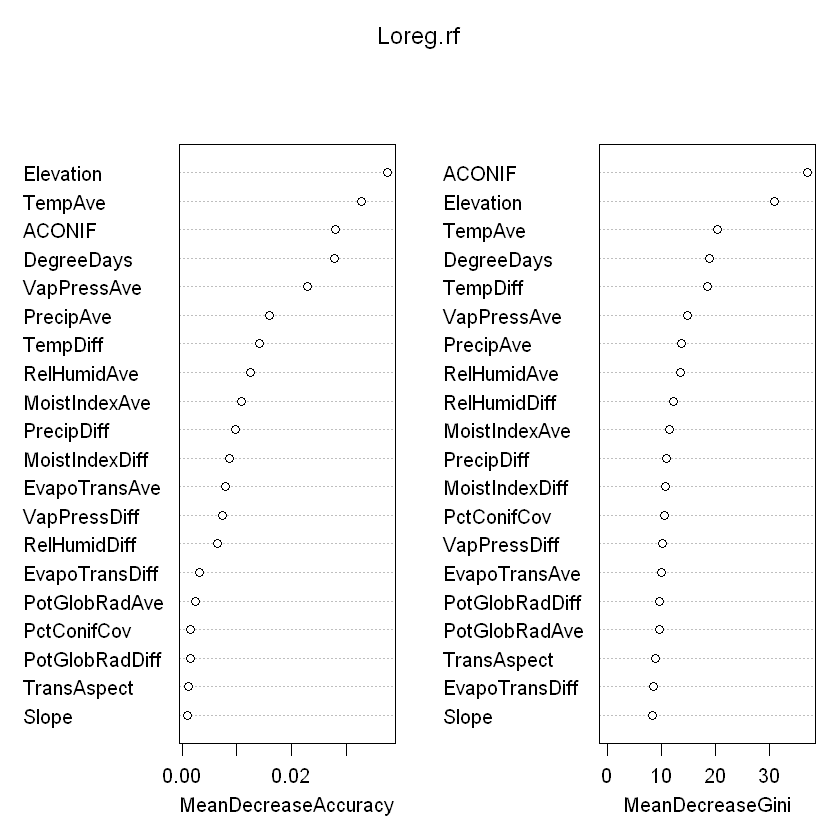

In [13]:
set.seed(5341)

Loreg.rf=randomForest(as.factor(LobaOreg)~ . ,importance=TRUE,data=lichenLO)
varImpPlot(Loreg.rf,scale=FALSE)

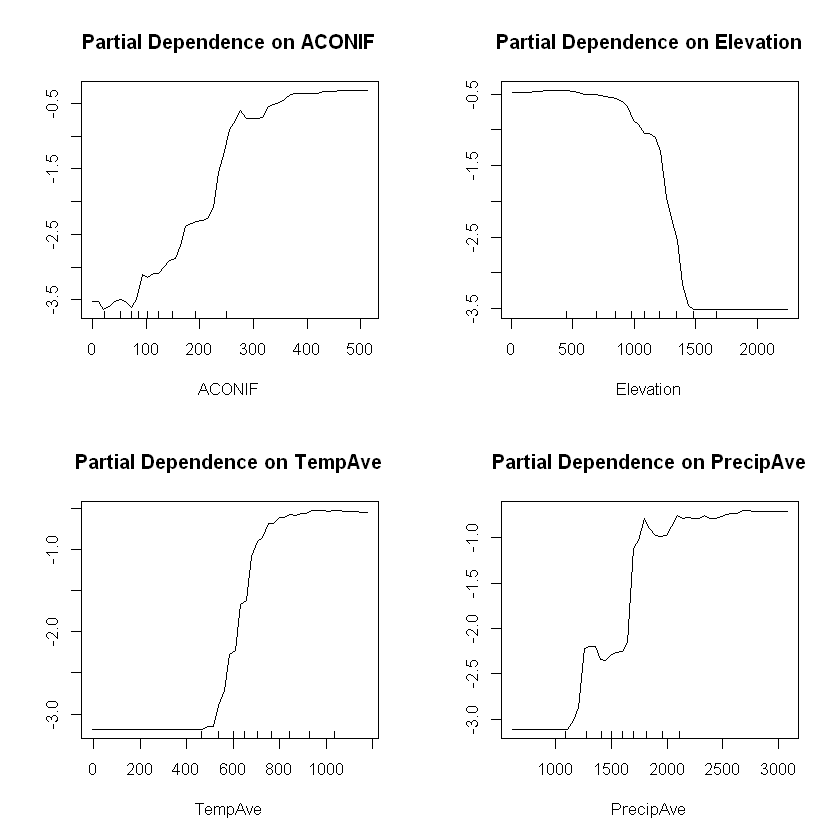

In [14]:
set.seed(5341)

Loreg.rf=randomForest(as.factor(LobaOreg)~ . ,importance=TRUE,keep.forest=TRUE,data=lichenLO)
par(mfrow=c(2,2))
partialPlot(Loreg.rf,lichenLO,ACONIF,which.class=1)
partialPlot(Loreg.rf,lichenLO,Elevation,which.class=1)
partialPlot(Loreg.rf,lichenLO,TempAve,which.class=1)
partialPlot(Loreg.rf,lichenLO,PrecipAve,which.class=1)

# Question 2 A

In [15]:
glass <- read.csv("../../Data/Glass.csv")

In [16]:
head(glass)

Refindex,Sodium,Magnesium,Aluminum,Silicon,Potassium,Calcium,Barium,Iron,GlassType
1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0,0.00,1
1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0,0.00,1
1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0,0.00,1
1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0,0.00,1
1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0,0.00,1
1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0,0.26,1


In [17]:
set.seed(5341)
Glass.rf=randomForest(as.factor(GlassType) ~ . ,importance=TRUE,data=glass)

glass.rf.confusion = Glass.rf$confusion
glass.rf.confusion
table(Actual = glass$GlassType, Predicted = predict(Glass.rf,type="class"))
print("Accuracy:")
100*sum(diag(glass.rf.confusion))/sum(glass.rf.confusion)

1,2,3,4,5,6,class.error
61,6,3,0,0,0,0.1285714
10,61,1,1,2,1,0.1973684
7,4,6,0,0,0,0.6470588
0,2,0,10,0,1,0.2307692
0,2,0,0,7,0,0.2222222
1,2,0,0,0,26,0.1034483


      Predicted
Actual  1  2  3  4  5  6
     1 61  6  3  0  0  0
     2 10 61  1  1  2  1
     3  7  4  6  0  0  0
     4  0  2  0 10  0  1
     5  0  2  0  0  7  0
     6  1  2  0  0  0 26

[1] "Accuracy:"


[1] 79.33951

In [18]:
Glass.rf$confusion
Glass.rf$confusion[3,7]

1,2,3,4,5,6,class.error
61,6,3,0,0,0,0.1285714
10,61,1,1,2,1,0.1973684
7,4,6,0,0,0,0.6470588
0,2,0,10,0,1,0.2307692
0,2,0,0,7,0,0.2222222
1,2,0,0,0,26,0.1034483


[1] 0.6470588

In [19]:
glass.rf.confusion[3,7]

[1] 0.6470588

# 2B

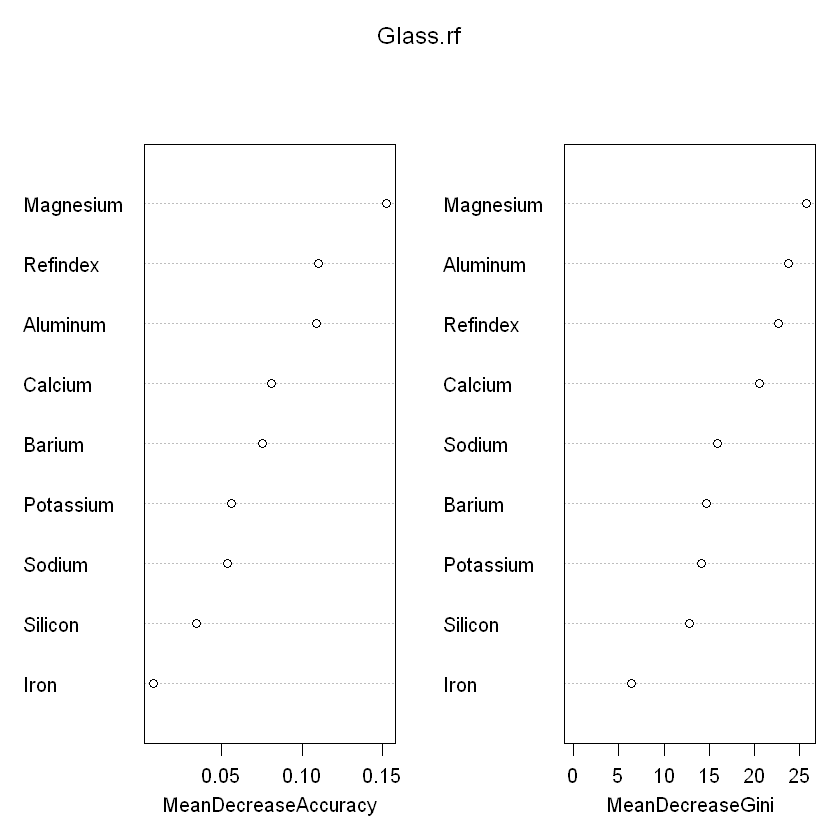

In [20]:
varImpPlot(Glass.rf,scale=FALSE)

In [21]:
Glass.var=subset(glass,select=c(GlassType, Magnesium, Refindex, 
                                Aluminum, Calcium, Barium, Potassium,
                                Sodium, Silicon, Iron))

In [22]:
set.seed(5341)

Glass.var.rf=randomForest(as.factor(GlassType) ~ . ,
                      importance=TRUE,
                      data=Glass.var)

glass.vrf.confusion = Glass.var.rf$confusion
glass.vrf.confusion

print("Accuracy:")
accuracy = 100*sum(diag(glass.vrf.confusion))/sum(glass.vrf.confusion)
accuracy

1,2,3,4,5,6,class.error
62,6,2,0,0,0,0.1142857
8,63,1,1,2,1,0.1710526
6,3,8,0,0,0,0.5294118
0,3,0,9,0,1,0.3076923
0,2,0,0,7,0,0.2222222
1,2,0,0,0,26,0.1034483


[1] "Accuracy:"


[1] 81.22605

# 3A

In [23]:
nest <- read.csv("../../Data/Nest.csv")

In [24]:
set.seed(5341)

nest.rf=randomForest(as.factor(Species) ~ . ,
                      importance=TRUE,
                      data=nest)

nest.rf.confusion = nest.rf$confusion
nest.rf.confusion

print("Accuracy:")
accuracy = 100*sum(diag(nest.rf.confusion))/sum(nest.rf.confusion)
accuracy

,Chickadee,Flicker,Non-nest,Sapsucker,class.error
Chickadee,23,1,0,18,0.4523810
Flicker,5,6,0,12,0.7391304
Non-nest,0,0,106,0,0.0000000
Sapsucker,14,8,0,20,0.5238095


[1] "Accuracy:"


[1] 72.18861

In [25]:
nest.rf.confusion[4,5]

[1] 0.5238095

# 3B

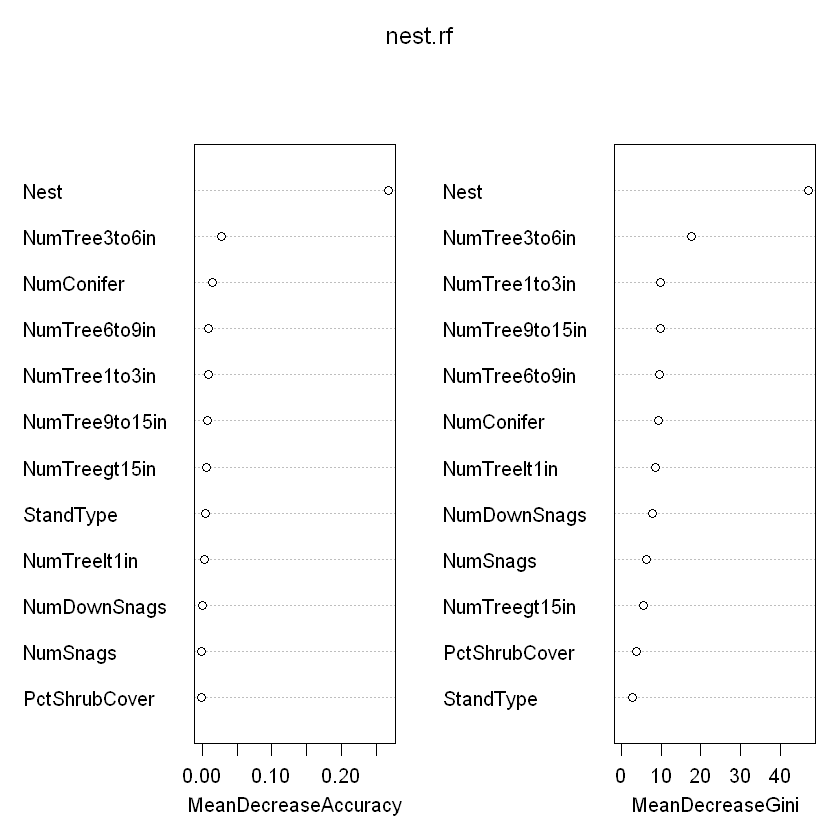

In [26]:
varImpPlot(nest.rf,scale=FALSE)

In [27]:
nest.var = subset(nest, select = c(Species, Nest, NumTree3to6in, NumConifer,
                                  NumTree6to9in))

set.seed(5341)

nest.var.rf = randomForest(as.factor(Species) ~ . ,
                      importance=TRUE,
                      data=nest.var)

nest.vrf.confusion = nest.var.rf$confusion
nest.vrf.confusion

print("Accuracy:")
accuracy1 = 100*sum(diag(nest.vrf.confusion))/sum(nest.vrf.confusion)
accuracy1

,Chickadee,Flicker,Non-nest,Sapsucker,class.error
Chickadee,27,2,0,13,0.3571429
Flicker,6,8,0,9,0.6521739
Non-nest,0,0,106,0,0.0000000
Sapsucker,14,8,0,20,0.5238095


[1] "Accuracy:"


[1] 75.04669

# 4A

In [28]:
set.seed(5341)

nest.nrf=randomForest(as.factor(Nest) ~ . - Species,
                      importance=TRUE,
                      data=nest)

nest.nrf.confusion = nest.nrf$confusion
nest.nrf.confusion

print("Accuracy:")
accuracy = 100*sum(diag(nest.nrf.confusion))/sum(nest.nrf.confusion)
accuracy

,0,1,class.error
0,87,19,0.1792453
1,16,91,0.1495327


[1] "Accuracy:"


[1] 83.43928

# 4B

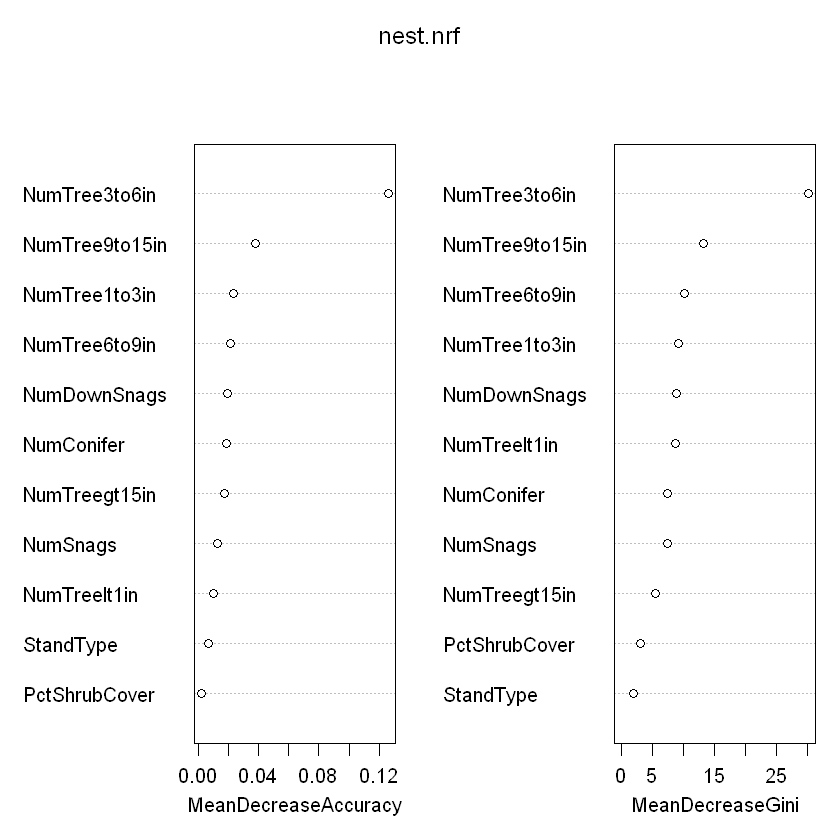

In [29]:
varImpPlot(nest.nrf,scale=FALSE)

In [30]:
nest.nvar = subset(nest, select = c(Nest, NumTree3to6in, NumTree9to15in,
                                   NumTree1to3in, NumTree6to9in, NumDownSnags,
                                   NumConifer, NumTreegt15in, NumSnags, NumTreelt1in))

set.seed(5341)

nest.nv.rf = randomForest(as.factor(Nest) ~ . ,
                      importance=TRUE,
                      data=nest.nvar)

nest.nvrf.confusion = nest.nv.rf$confusion
nest.nvrf.confusion

print("Accuracy:")
accuracy4 = 100*sum(diag(nest.nvrf.confusion))/sum(nest.nvrf.confusion)
accuracy4

,0,1,class.error
0,93,13,0.1226415
1,17,90,0.1588785


[1] "Accuracy:"


[1] 85.80209

# 4C

In [31]:
Nests = subset(nest, select = c(Nest, NumTree3to6in, NumTree9to15in,
                                NumTree1to3in, NumTree6to9in, NumDownSnags,
                                NumConifer, NumTreegt15in, NumSnags, 
                                NumTreelt1in, StandType, PctShrubCover))
set.seed(529)
Nests.ada.xvalpr=rep(0,nrow(Nests))
xvs=rep(1:10,length=nrow(Nests))
xvs=sample(xvs)
for(i in 1:10){
      train=Nests[xvs!=i,]
      test=Nests[xvs==i,]
      glub=ada(as.factor(Nest)~ . ,loss="exponential",data=train)
      Nests.ada.xvalpr[xvs==i]=predict(glub,newdata=test,type="prob")[,2]
}

table(Nests$Nest,round(Nests.ada.xvalpr))
class.sum(Nests$Nest,Nests.ada.xvalpr)

   
     0  1
  0 88 18
  1 19 88

Percent Correctly Classified =,82.63
Specificity =,83.02
Sensitivity =,82.24
Kappa =,0.6526
AUC=,0.873


# 4D 

In [32]:
set.seed(424)
Nests.gbm.xvalpr=rep(0,nrow(Nests))
xvs=rep(1:10,length=nrow(Nests))
xvs=sample(xvs)
for(i in 1:10){
      train=Nests[xvs!=i,]
      test=Nests[xvs==i,]
      glub=gbm(Nest~ . ,distribution="bernoulli",n.trees=5000,data=train)
      Nests.gbm.xvalpr[xvs==i]=predict(glub,newdata=test,type="response",n.trees=5000)
}

table(Nests$Nest,round(Nests.gbm.xvalpr))
class.sum(Nests$Nest,Nests.gbm.xvalpr)

   
     0  1
  0 78 28
  1 27 80

Percent Correctly Classified =,74.18
Specificity =,73.58
Sensitivity =,74.77
Kappa =,0.4835
AUC=,0.8273


In [33]:
# set.seed(732)
# fitControl = trainControl(method = "cv", number = 10 )

# gbmGrid = expand.grid(interaction.depth = c(12, 14, 16, 18, 20), 
#                       n.trees = c(25,50,75,100), 
#                       shrinkage = c(0.01, 0.05, 0.1, 0.2 ), 
#                       n.minobsinnode=10)
# gbmFit = train( as.factor(Nest)~ . , 
#                method="gbm", 
#                tuneGrid = gbmGrid, 
#                trControl = fitControl, 
#                data=Nests)
# gbmFit

In [34]:
Nests.gbmopt.xvalpr=rep(0,nrow(Nests))
xvs=rep(1:10,length=nrow(Nests))
xvs=sample(xvs)
for(i in 1:10){
      train=Nests[xvs!=i,]
      test=Nests[xvs==i,]
      glub=gbm(Nest~ . ,
               distribution="bernoulli",
               interaction.depth=14,
               n.trees=75, 
               shrinkage=0.1,
               n.minobsinnode=10,
               data=train)
      Nests.gbmopt.xvalpr[xvs==i]=predict(glub,
                                             newdata=test,
                                             type="response",
                                             n.trees=75)
}

table(Nests$Nest,round(Nests.gbmopt.xvalpr))
class.sum(Nests$Nest,Nests.gbmopt.xvalpr)

   
     0  1
  0 90 16
  1 17 90

Percent Correctly Classified =,84.51
Specificity =,84.91
Sensitivity =,84.11
Kappa =,0.6901
AUC=,0.8996


# 4 E

In [35]:
library(e1071)

In [36]:
set.seed(424)

Nests.svm.xvalpred=rep(0,nrow(Nests))
xvs=rep(1:10,length=nrow(Nests))
xvs=sample(xvs)
for(i in 1:10){
      train=Nests[xvs!=i,]
      test=Nests[xvs==i,]
      glub=svm(as.factor(Nest)~ . ,probability=TRUE,data=train)
      Nests.svm.xvalpred[xvs==i]=attr(predict(glub,test,probability=TRUE),"probabilities")[,2]
}

table(Nests$Nest,round(Nests.svm.xvalpred))
class.sum(Nests$Nest,Nests.svm.xvalpred)

   
     0  1
  0 90 16
  1 13 94

Percent Correctly Classified =,86.38
Specificity =,84.91
Sensitivity =,87.85
Kappa =,0.7277
AUC=,0.9035



Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 gamma cost
  0.04    8

- best performance: 0.1264069 

- Detailed performance results:
   gamma cost     error dispersion
1   0.02    1 0.2151515 0.10539444
2   0.04    1 0.1965368 0.10267034
3   0.08    1 0.1636364 0.09896507
4   0.16    1 0.1545455 0.07650085
5   0.32    1 0.1686147 0.05844111
6   0.02    2 0.1822511 0.09350493
7   0.04    2 0.1588745 0.11276297
8   0.08    2 0.1590909 0.08594797
9   0.16    2 0.1448052 0.07323463
10  0.32    2 0.1781385 0.06474278
11  0.02    4 0.1729437 0.11026670
12  0.04    4 0.1450216 0.09760281
13  0.08    4 0.1354978 0.08029885
14  0.16    4 0.1638528 0.06579557
15  0.32    4 0.1733766 0.07615473
16  0.02    8 0.1590909 0.09433329
17  0.04    8 0.1264069 0.06947569
18  0.08    8 0.1313853 0.06208303
19  0.16    8 0.1874459 0.06512079
20  0.32    8 0.1826840 0.07408095


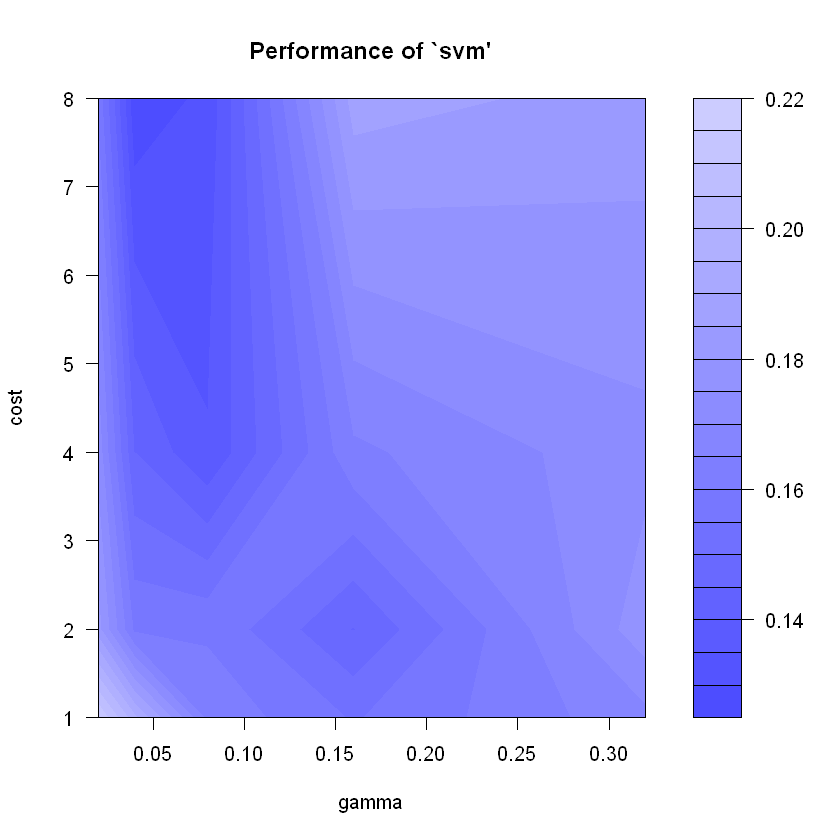

In [37]:
Nests.tunesvm=tune.svm(as.factor(Nest)~ . ,
                       data=Nests, 
                       gamma=c(0.02,0.04,0.08,0.16,0.32),
                       cost=c(1,2,4,8))

plot(Nests.tunesvm)

summary(Nests.tunesvm)

In [38]:
set.seed(425)

Nests.svm2.xvalpred=rep(0,nrow(Nests))
xvs=rep(1:10,length=nrow(Nests))
xvs=sample(xvs)
for(i in 1:10){
      train=Nests[xvs!=i,]
      test=Nests[xvs==i,]
      glub=svm(as.factor(Nest)~ . ,
               gamma=0.04,
               cost=8,
               probability=TRUE,
               data=train)
      Nests.svm2.xvalpred[xvs==i]=attr(predict(glub,
                                               test,
                                               probability=TRUE),
                                       "probabilities")[,2]
}

table(Nests$Nest,round(Nests.svm2.xvalpred))
class.sum(Nests$Nest,Nests.svm2.xvalpred)

   
     0  1
  0 92 14
  1 11 96

Percent Correctly Classified =,88.26
Specificity =,86.79
Sensitivity =,89.72
Kappa =,0.7652
AUC=,0.9049
